<a href="https://colab.research.google.com/github/NissrineH/ENSIAS/blob/master/DeepLearning_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> ##   *Deep Learning : Nissrine Hatibi*
> ## ***Classification des Séquences Promotrices du Génome Humain***
---


## *Modules et Packages*






In [5]:
!pip install biopython

     |████████████████████████████████| 2.3MB 7.0MB/s 


In [6]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

# ***Classification des séquences promotrices du génome humain suivant l'approche ULMFiT***

**Un Promoteur**



```
Un promoteur, ou séquence promotrice, est une région de l'ADN située à proximité d'un gène et est indispensable à la transcription de l'ADN en ARN.
Le promoteur est la zone de l'ADN sur laquelle se fixe initialement l'ARN polymérase, avant de démarrer la synthèse de l'ARN.
```



**ULMFiT**



```
ULMFiT (Universal Language Model Fine-tuning for Text Classification) est une méthode de Transfer Learning pour les tâches NLP.
```



**Transfer Learning**



```
Le Transfer Learning est le processus consistant à utiliser un modèle formé pour résoudre une tâche comme base pour résoudre une autre tâche.
Cela signifie qu'au lieu de former un modèle à partir de zéro pour la deuxième tâche, on initialise le modèle avec les poids appris de la tâche initiale, 
puis on affine les poids vers la deuxième tâche.
```



## *Human Genome Data Processing*






In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Données**



```
Les ensembles de données utilisés pour les tâches de classification sont extraits de la publication existante :
« Recognition of Prokaryotic and Eukaryotic Promoters using Convolutional Deep Learning Neural Networks» .
```



In [8]:
path = '/content/drive/MyDrive/DeepLearning Project Notebook/Data/'
fname1 = '/content/drive/MyDrive/DeepLearning Project Notebook/Data/human_non_tata.fa'
fname2 = '/content/drive/MyDrive/DeepLearning Project Notebook/Data/human_nonprom_big.fa'

In [9]:
fasta1 = SeqIO.parse(fname1, 'fasta')
seqs1 = [i.seq.__str__() for i in fasta1 if set(i.seq.__str__()) == set('ATGC')]
seq1_df = pd.DataFrame(seqs1, columns=['Sequence'])
seq1_df['Promoter'] = 1

In [10]:
fasta2 = SeqIO.parse(fname2, 'fasta')
seqs2 = [i.seq.__str__() for i in fasta2 if set(i.seq.__str__()) == set('ATGC')]
seq2_df = pd.DataFrame(seqs2, columns=['Sequence'])
seq2_df['Promoter'] = 0

In [11]:
seq1_df.shape, seq2_df.shape

((19809, 2), (27703, 2))

In [12]:
seq1_df.drop_duplicates(inplace=True)
seq2_df.drop_duplicates(inplace=True)

In [13]:
seq1_df.shape, seq2_df.shape

((19787, 2), (27038, 2))



```
15% de séquences vont être utilisées  pour le test. 
Du 85% séquences réstantes, 90% vont être utilisées pour l'entrainement et 10% vont être utilisées pour la validation.
```

In [14]:
def partition_data(df):
    
    train_size = int(len(df)*0.85*.9)
    valid_size = int(len(df)*0.85) - train_size
    
    train_df = df.sample(train_size)
    test_val = df.drop(train_df.index)
    valid_df = test_val.sample(valid_size)
    test_df = test_val.drop(valid_df.index)
    train_df['set'] = 'train'
    valid_df['set'] = 'valid'
    test_df['set'] = 'test'
    
    return (train_df, valid_df, test_df)

In [15]:
t1, v1, test1 = partition_data(seq1_df)
t2, v2, test2 = partition_data(seq2_df)
data_df = pd.concat([t1,t2,v1,v2,test1,test2])

In [16]:
data_df[data_df.set == 'train'].shape, data_df[data_df.set == 'valid'].shape, data_df[data_df.set == 'test'].shape, data_df.shape

((35821, 3), (3979, 3), (7025, 3), (46825, 3))

In [17]:
data_df.to_csv('/content/drive/MyDrive/DeepLearning Project Notebook/Output/human_promoters_short.csv', index=False)

## *Human Promoter Classification Naïve Model*


In [18]:
sys.path.append("/content/drive/MyDrive/DeepLearning Project Notebook/")
from utils import *

**Chargement des données**

In [19]:
classification_df = pd.read_csv('/content/drive/MyDrive/DeepLearning Project Notebook/Output/human_promoters_short.csv')

In [20]:
classification_df.head()

,Sequence,Promoter,set
0,GCGTCCGCTTCTCACCTCAGGTCTCCCTTCGGCCCCGCTGCCCTCC...,1,train
1,TCTCTCCTCCCCTCTCCTCTCCTTCCCCCCTCCCCTCCCCTCCCCG...,1,train
2,GGTGGGCGGGAACCGGGAGGGGCCGGCCGAGCCCCCTTCCTCGGGG...,1,train
3,TCTGAGCCCAGGACTGAGGTAGGGGTTACTTCGGGCTGAGGGGATT...,1,train
4,TCCCTCCCTGGGCGAAAAACTTCTTACAAAAAGTTAATCACTGCCC...,1,train


**Partitionnement des données**

In [21]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [18]:
train_df.shape, valid_df.shape, test_df.shape

((35821, 3), (3979, 3), (7025, 3))

**Tokenisation et Numérisation**



```
Si on veut former un Sequence Model sur des données génomiques, on doit premièrement traiter ces données sous une forme qui peut être utilisée par un réseau de neurones .
Donc on doit transformer les données de séquences en une forme numérique qui peut être manipulée mathématiquement.
Et ça est fait en 2 étapes :
  * La tokenisation : est le processus de décomposition de la séquence en sous-unités ou en tokens.
  * La numérisation : est le processus de mappage de tokens sur des valeurs entières. 
```



In [22]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [23]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, test_df=test_df, tokenizer=tok, text_cols='Sequence', label_cols='Promoter', bs=400)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


  Tokenisation (k-mers = 5 - stride = 2)



In [21]:
data_clas.train_ds

LabelList (35821 items)
x: TextList
CACGT CGTGG TGGGG GGGCA GCACG ACGGG GGGGC GGCGG CGGGG GGGCG GCGCG GCGCG GCGCT GCTGG TGGGC GGCTG CTGGG GGGGA GGAGG AGGAG GAGCG GCGGC GGCTC CTCGA CGAAC AACTT CTTTG TTGGT GGTGG TGGCG GCGGC GGCGT CGTCT TCTGC TGCGG CGGGA GGAGG AGGGG GGGGA GGAGG AGGAG GAGTG GTGGG GGGCA GCACT ACTTG TTGAC GACAG CAGCG GCGGG GGGGG GGGGA GGAGG AGGGG GGGAA GAAGG AGGGC GGCGC CGCAG CAGAG GAGGA GGAAA AAAGG AGGGG GGGGA GGATG ATGGG GGGAA GAAGC AGCGA CGAGG AGGCA GCAGG AGGAG GAGGG GGGGG GGGAG GAGGG GGGGC GGCCT CCTCG TCGGC GGCAA CAAGC AGCCC CCCAG CAGAA GAAAA AAAAA AAACG ACGAC GACAA CAACG ACGCG GCGAG GAGAA GAAAA AAAAT AATTA TTAGT AGTAT TATTT TTTTT TTTGC TGCAC CACTT CTTCA TCACA ACAAA AAATT ATTAA TAATG ATGAC GACCA CCATG ATGAG GAGCT GCTCG TCGTT GTTTT TTTTG TTGAT GATAA TAAAC,AGACC ACCCT CCTGC TGCGG CGGTG GTGGG GGGTG GTGTG GTGAC GACCC CCCTA CTAGG AGGAC GACCG CCGGA GGAAG AAGAG GAGTA GTAAA AAACC ACCCG CCGAA GAAGA AGAAA AAAGA AGACG ACGAA GAAAG AAGAC GACTA CTACA ACAAA AAATC ATCCT CCTAG TAGTG GTGA

Numerisation

In [22]:
data_clas.train_ds[0][0].data

array([862, 469,  28, 125, ..., 153, 621, 800, 809])

**Classification Model**



```
Un Classification Model est un modèle qui prend une séquence de tokens et prédit à quelle catégorie ou classe appartient cette séquence.
```



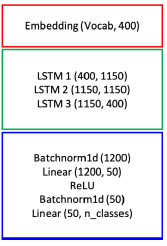

In [23]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [24]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [25]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, ep

In [26]:
learn.unfreeze()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


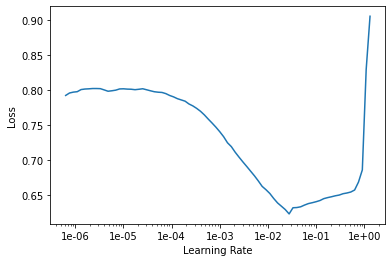

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(5, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.447039,0.394171,0.836642,03:40
1,0.394011,0.566422,0.659462,03:39
2,0.366927,0.357158,0.848454,03:39
3,0.338968,0.343443,0.852476,03:39
4,0.312057,0.329651,0.862277,03:40


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [29]:
learn.fit_one_cycle(5, 3e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.300706,0.330338,0.864036,03:40
1,0.304836,0.327868,0.863031,03:40
2,0.288568,0.329019,0.861272,03:40
3,0.272903,0.319197,0.868309,03:41
4,0.258918,0.319868,0.868309,03:41


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [30]:
#learn.save('hum_prom_short1')

**Test**

In [31]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, text_cols='Sequence', label_cols='Promoter', bs=400)
learn.data = data_clas

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [32]:
get_scores(learn)

Accuracy: 0.8646263345195729
False Positives: 0.02106761565836299
False Negatives: 0.11430604982206406
Recall: 0.729538565173459
Precision: 0.9360414866032843
Specificity: 0.9635108481262328
MCC: 0.7284169493716117


In [33]:
#learn.lr_find()
#learn.recorder.plot_losses()

## *Human Language Model*

**Données**



```
Pour créer des ensembles de données pour la formation du general domain genomic language model, les génomes complets sont téléchargés à partir du NCBI.
```



In [34]:
fname = '/content/drive/MyDrive/DeepLearning Project Notebook/Data/GCF_000001405.30_GRCh38.p4_rna.fna'

In [35]:
data = process_fasta(fname, 10000, 2000)

In [36]:
df = pd.DataFrame(data, columns=['Sequence'])
df['Source'] = 'NCBI Human'

df.to_csv('/content/drive/MyDrive/DeepLearning Project Notebook/Output/human_genome_data.csv', index=False)

In [37]:
def get_init_vocab(ret='data'):
    df = next(pd.read_csv('/content/drive/MyDrive/DeepLearning Project Notebook/Output/human_genome_data.csv', chunksize=100))
    cut = int(len(df)*0.8) + 1
    train_df = df[:cut]
    valid_df = df[cut:]
    data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=400, tokenizer=tok, 
                                  text_cols=0, label_cols=1)
    if ret=='data':
        return data
    else:
        return data.vocab

In [38]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [39]:
init_voc = get_init_vocab()
np.save('/content/drive/MyDrive/DeepLearning Project Notebook/Output/human_vocab_5mer.npy', init_voc.vocab.itos)

**Language Model**



```
Un Language Model est un modèle qui prend une séquence de tokens k mer et prédit le token suivant dans la séquence.
```



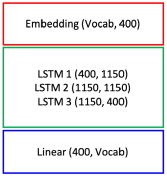

In [40]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)

In [ ]:
drop_mult = 0.6
lr = 2e-2
count = 1
df_chunks = pd.read_csv('/content/drive/MyDrive/DeepLearning Project Notebook/Output/human_genome_data.csv', chunksize=100000)
for df in df_chunks:
    
    if count == 1:
        voc = np.load('/content/drive/MyDrive/DeepLearning Project Notebook/Output/human_vocab_5mer.npy')
        model_vocab = GenomicVocab(voc)
        
        cut = int(len(df)*0.8) + 1
        train_df = df[:cut]
        valid_df = df[cut:]
        data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=400, tokenizer=tok, vocab=model_vocab,
                                      chunksize=10000, text_cols=0, label_cols=1)
        learn = get_model_LM(data, drop_mult, config)
        
    else:
        data = GenomicTextLMDataBunch.from_df(path, df, valid_df, bs=400, tokenizer=tok, 
                                      chunksize=10000, text_cols=0, label_cols=1, vocab=model_vocab)
        
    learn.data = data
    lr_iter = lr/(1.5**count)
    print(f'Learning Rate: {lr_iter}')
    learn.fit_one_cycle(1, lr_iter, moms=(0.8,0.7), pct_start=0.4)
    count += 1


In [ ]:
learn.save('human_genome_full')
learn.save_encoder('human_genome_full_enc')

## *Human Short Promoter Classification with Genomic Pretraining*



```
Les poids sont utilisés à partir du Language Model formé pour initialiser le modèle de classification.
```



In [26]:
voc = np.load('/content/drive/MyDrive/DeepLearning Project Notebook/Output/human_vocab_5mer.npy')
model_vocab = GenomicVocab(voc)

In [42]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,text_cols='Sequence', label_cols='Promoter', bs=400)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


**Le modèle**

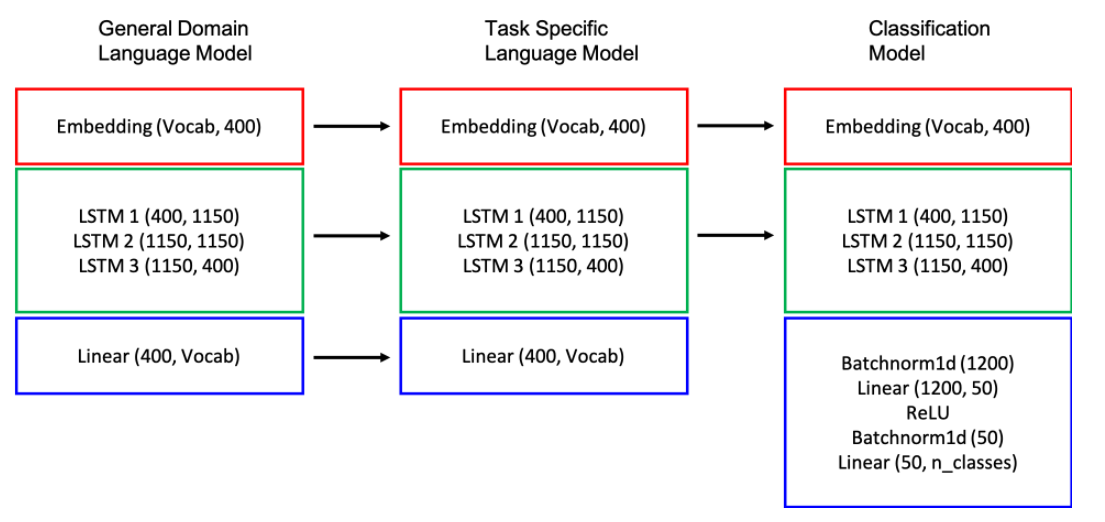

In [43]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.6

In [44]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [45]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.24, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, e

In [46]:
learn.load_encoder('human_genome_full_enc')
learn.freeze()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


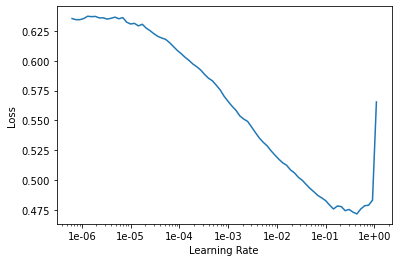

In [47]:
learn.lr_find()
learn.recorder.plot()

**Train** 

In [48]:
learn.fit_one_cycle(6, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.386522,0.358593,0.849208,01:33
1,0.374080,0.341204,0.861523,01:32
2,0.365486,0.335091,0.857753,01:33
3,0.355384,0.327503,0.860266,01:33
4,0.351556,0.325386,0.861272,01:32
5,0.344485,0.321166,0.863534,01:33


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [49]:
learn.freeze_to(-2)
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.335474,0.316814,0.865041,01:52
1,0.332767,0.329994,0.863282,01:52
2,0.315845,0.304868,0.873586,01:51
3,0.292885,0.287381,0.879367,01:52
4,0.273572,0.282813,0.881629,01:51
5,0.259713,0.276668,0.885147,01:52


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [50]:
learn.freeze_to(-3)
learn.fit_one_cycle(6, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.255931,0.276248,0.886152,02:53
1,0.259149,0.272275,0.886906,02:53
2,0.249507,0.272152,0.887660,02:52
3,0.235974,0.265633,0.889419,02:52
4,0.221155,0.272339,0.890676,02:53
5,0.214214,0.269124,0.893692,02:53


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [51]:
learn.freeze_to(-4)
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.214910,0.273305,0.892938,03:43
1,0.234659,0.267476,0.892184,03:41
2,0.230982,0.264732,0.893441,03:42
3,0.206628,0.273666,0.898718,03:42
4,0.185162,0.272907,0.897964,03:42
5,0.163196,0.269434,0.900226,03:42


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [52]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.159105,0.270800,0.898467,03:43
1,0.158231,0.272376,0.900226,03:43
2,0.157107,0.267426,0.899724,03:43
3,0.151527,0.272136,0.905001,03:43
4,0.148366,0.275955,0.902991,03:43
5,0.146923,0.272029,0.903745,03:43
6,0.144038,0.271463,0.904247,03:43
7,0.142007,0.273781,0.905755,03:43
8,0.140101,0.274773,0.906258,03:43
9,0.140144,0.274455,0.905755,03:43


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [53]:
learn.fit_one_cycle(10, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.139408,0.279041,0.903242,03:43
1,0.144491,0.277693,0.904247,03:43
2,0.150549,0.286310,0.905001,03:43
3,0.146211,0.265912,0.906258,03:42
4,0.137873,0.275750,0.905504,03:44
5,0.130449,0.269334,0.908771,03:43
6,0.117413,0.273230,0.912541,03:42
7,0.107980,0.275415,0.910028,03:42
8,0.099941,0.280210,0.912038,03:43
9,0.098324,0.285568,0.910530,03:42


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [54]:
learn.fit_one_cycle(10, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.095471,0.283372,0.912290,03:42
1,0.094268,0.278238,0.912290,03:43
2,0.095202,0.283066,0.913043,03:43
3,0.093414,0.288347,0.912792,03:42
4,0.093294,0.292343,0.912038,03:43
5,0.093646,0.295769,0.909776,03:42
6,0.090655,0.290442,0.912038,03:42
7,0.090354,0.288515,0.911033,03:43
8,0.087362,0.292603,0.910782,03:44
9,0.084573,0.292758,0.911033,03:44


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [55]:
learn.save('human_short_human_pretrain')

**Test**

In [56]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab, text_cols='Sequence', label_cols='Promoter', bs=400)
learn.data = data_clas

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [57]:
get_scores(learn)

Accuracy: 0.9104626334519573
False Positives: 0.01807829181494662
False Negatives: 0.07145907473309608
Recall: 0.8309195015156619
Precision: 0.9510408635312259
Specificity: 0.9686883629191322
MCC: 0.8184558702949016


In [ ]:
#learn.lr_find()
#learn.recorder.plot_losses()

## *Human Short Promoter Classification with Genomic Pretraining and Fine Tuning*



```
Après avoir former le General Language Model sur un grand dataset non supervisé étiqueté, on fine-tune le 
General Language Model sur la data de classification, pour créer un Language Model spécifique à la tâche. 
Et ensuite, on fine-tune le Language Model spécifique à la tâche pour la classification. 
```



In [27]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=400, tokenizer=tok, chunksize=10000, text_cols='Sequence', label_cols='Promoter', vocab=model_vocab)

In [28]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [29]:
learn = get_model_LM(data, drop_mult, config)



```
Initialisation du modèle en chargeant les poids du modèle de langage du génome humain.
```





In [30]:
learn.load('human_genome_full');

In [31]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


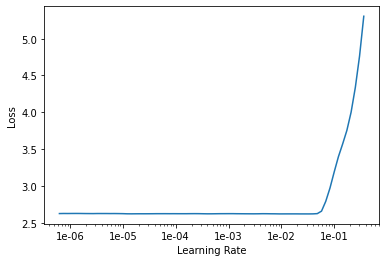

In [32]:
learn.lr_find()
learn.recorder.plot()

**Training** 

In [33]:
learn.fit_one_cycle(10, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.610984,2.586391,0.182907,03:38
1,2.599163,2.574878,0.186123,03:39
2,2.583407,2.557398,0.193435,03:39
3,2.547895,2.527858,0.204851,03:39
4,2.509119,2.494340,0.217034,03:40
5,2.469562,2.459473,0.230869,03:39
6,2.424292,2.426203,0.245502,03:40
7,2.380127,2.401767,0.256101,03:39
8,2.354992,2.390496,0.260879,03:39
9,2.348958,2.388955,0.261665,03:39


In [34]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.346087,2.385112,0.263242,03:39
1,2.339130,2.371171,0.269865,03:40
2,2.314668,2.341786,0.282069,03:39
3,2.272228,2.307153,0.296530,03:39
4,2.224717,2.271361,0.311371,03:39
5,2.187312,2.240894,0.324817,03:39
6,2.150788,2.217102,0.334206,03:40
7,2.120950,2.201706,0.339919,03:39
8,2.105220,2.195087,0.342611,03:39
9,2.097824,2.194195,0.343173,03:39


In [35]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.098302,2.189963,0.344901,03:39
1,2.096779,2.178634,0.349508,03:39
2,2.083438,2.159554,0.358105,03:39
3,2.043166,2.126584,0.371149,03:39
4,2.000916,2.089607,0.384125,03:39
5,1.963084,2.062608,0.394915,03:40
6,1.929484,2.039684,0.403829,03:39
7,1.904226,2.025706,0.408462,03:39
8,1.891271,2.019490,0.410516,03:39
9,1.874556,2.018422,0.410958,03:39


In [36]:
learn.fit_one_cycle(10, 8e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.878427,2.015944,0.412022,03:40
1,1.881497,2.010292,0.413927,03:39
2,1.876098,1.994306,0.419657,03:39
3,1.847373,1.974001,0.426837,03:39
4,1.823890,1.951042,0.434802,03:39
5,1.791731,1.933140,0.441925,03:39
6,1.769428,1.917760,0.447232,03:39
7,1.750255,1.909083,0.451216,03:39
8,1.734128,1.904776,0.452792,03:39
9,1.728518,1.904127,0.453117,03:40


In [37]:
learn.save('human_LM_short_finetune')
learn.save_encoder('human_LM_short_finetune_enc')

**Classification** 

In [38]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, text_cols='Sequence', label_cols='Promoter', bs=400)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [39]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [40]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [41]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, ep

In [42]:
learn.load_encoder('human_LM_short_finetune_enc')
learn.freeze()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


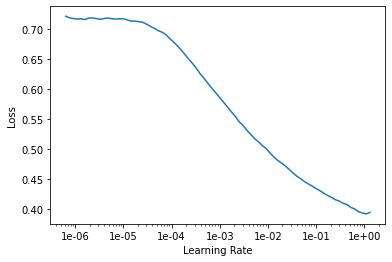

In [43]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 2e-2, moms=(0.8,0.7))

In [44]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.255396,0.218713,0.921337,01:49
1,0.223340,0.190767,0.928877,01:50
2,0.190672,0.179846,0.937421,01:49
3,0.157386,0.190213,0.940689,01:49


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [45]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.156880,0.148632,0.944961,02:48
1,0.150035,0.134580,0.949233,02:48
2,0.115858,0.124718,0.957276,02:49
3,0.092219,0.130184,0.957024,02:49


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [46]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.094923,0.116400,0.962553,03:37
1,0.100921,0.118428,0.958784,03:37
2,0.079905,0.107561,0.965821,03:38
3,0.063104,0.114563,0.965821,03:38


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [47]:
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.054500,0.112985,0.967328,03:37
1,0.053077,0.113556,0.967077,03:36
2,0.051668,0.114745,0.968082,03:37
3,0.045127,0.115945,0.967831,03:37


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [48]:
learn.save('human_short_human_pretrain_finetune')

**Test**

In [49]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab, text_cols='Sequence', label_cols='Promoter', bs=400)
learn.data = data_clas

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [50]:
get_scores(learn)

Accuracy: 0.9699644128113879
False Positives: 0.018790035587188614
False Negatives: 0.011245551601423487
Recall: 0.9733917143819468
Precision: 0.9563203176704169
Specificity: 0.9674556213017751
MCC: 0.9387138083129684


In [ ]:
#learn.lr_find()
#learn.recorder.plot_losses()

## *Résultats*  

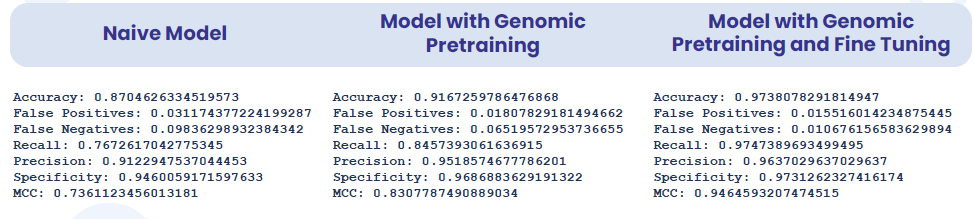

## *Conclusion* 



```
Le Transfer Learning est une étape extremement importante pour obtenir des résultats de haute qualité à partir du training sur de petit ensemble de données.
Les modèles formés à l'aide du Transfer Learning nécessite beaucoup plus moins de régularisations que les modèles formé à partir du scratch.
Cette amélioration des performances du Transfer Learning est ce qui permet à ULMFiT de travailler si efficacement sur de petits ensembles de données.
```

